# <center> Импорт библоиотек <center>

*NOTE*: не забудьте составить список библиотек, необходимых для реализации ваших решений, и представить их в файле `requirements.txt`.

In [305]:
import pickle
import random
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score , accuracy_score, confusion_matrix

# <center> Чтение данных <center>

Тренировчные данные представлены в виде файла в формате JSON. В котором верхенеуровневый ключ -- это номер образца (бакетрии). Каждый словарь по бактериям содержит название штамма и результаты масс-спектрометрического анализа, которые представлены следующими полями: масса к заряду (m/z), время (time), интенсивность пика (Intens.), разрешение (Res.), площадь пика (Area), относительная интенсивность (Rel. Intens.), ширина на полувысоте (FWHM=full width at half-maximum intensity). Каждый штамм будет представлен несколькими бактериями.

In [306]:
with open('input/train.json', 'rb') as fp:
    train_d = json.load(fp)
train_df = pd.DataFrame(json.loads(train_d)).T

In [307]:
train_df.shape

(256, 10)

In [308]:
## Посмотрим сколько классов данных и сколько примеров на каждый класс
train_df.groupby('strain').agg({'strain': "count"})

,strain
strain,
Acinetobacter baumani_121 skin,9
Acinetobacter baumani_126,9
Acinetobacter baumani_352 blood,10
Acinetobacter baumani_377 blood,11
Acinetobacter baumani_503 blood,11
Acinetobacter baumani_63,9
Acinetobacter baumani_64,11
Acinetobacter baumani_73,10
Acinetobacter baumani_74,11


Так как тренировочный набор данных не очень большой, дополним его симмулированными данными. Для этого составим дополнительные примеры из существующих. Зададим seed для воспроизводимости результатов.

In [309]:
# для начала орпеделим количестов пиков в масс-спектрах
train_df.loc[:,'n_peak'] = train_df['m/z'].apply(len)

In [310]:
def get_dif(x):
    return max(x) - min(x)

In [311]:
# посмотрим на сколько по количеству строк (пиков) различаются таблицы внутри каждого штамма
peaks_dif = train_df.groupby(['strain']).agg({'n_peak': get_dif})

<AxesSubplot: xlabel='n_peak', ylabel='Count'>

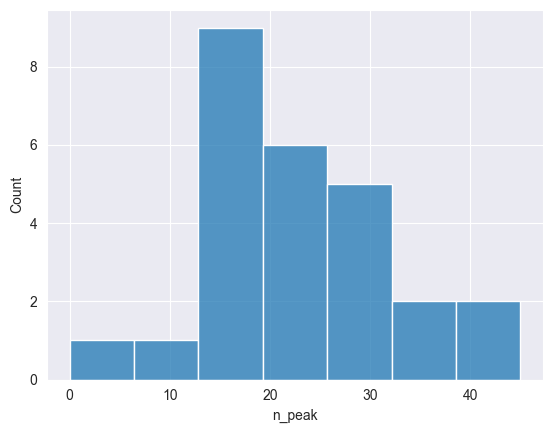

In [312]:
sns.histplot(peaks_dif.n_peak)

In [313]:
# будем использовать среднюю разности для варьирования числа пиков в сгенерированных данных
mean_dif = int(peaks_dif.n_peak.mean()) 

In [314]:
FEATURES = ['m/z', 'time', 'Intens.', 'SN', 'Res.', 'Area', 'Rel. Intens.',
            'FWHM', 'Bk. Peak']

In [315]:
np.random.seed(142)
train_gen = pd.DataFrame()
for strain in train_df.strain.unique():
    tmp = train_df[train_df.strain == strain]
    n_samples = tmp.shape[0]
    s = np.random.randint(max(tmp.n_peak) - mean_dif, max(tmp.n_peak), 6)
    strain_df = pd.DataFrame()
    
    for i,sample in enumerate(tmp[FEATURES].values):
        tmp_i = pd.DataFrame(list(sample)).T
        tmp_i.columns = FEATURES
        strain_df = pd.concat([strain_df, tmp_i])
    for i in range(0,6):
        df_i = pd.DataFrame()
        idx = []
        for n in range(0,s[i]):
            if isinstance(strain_df.loc[n], pd.Series):
                continue
            else:
                df_i = pd.concat([df_i, strain_df.loc[n].sample(n=1)])
        df_i[['id']] = i
        df_i.loc[:, 'strain'] = tmp.strain.unique()[0]
        df_i.loc[:, 'n_peak'] = n
        train_gen = pd.concat([train_gen, df_i])        

In [316]:
train_gen.shape

(12349, 12)

In [317]:
train_gen = train_gen.groupby(['strain', 'id']).agg(list).reset_index().drop(['id'], axis = 1)
train_gen.loc[:,'n_peak'] = train_gen.n_peak.apply(min)

C:\Users\micapic\AppData\Local\Temp\ipykernel_5504\3242894118.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_gen.loc[:,'n_peak'] = train_gen.n_peak.apply(min)


Совместим оригинальных датасет и сгенерированный.

In [318]:
train_df = pd.concat([train_df, train_gen[train_df.columns]])

In [319]:
train_df.shape

(412, 11)

# <center> Обработка данных и генерация признаков<center>

Пример таблицы с данными по масс-спектру для одного образца

In [320]:
example = train_df[FEATURES]\
         .loc[(train_df.strain == 'Staphilococcus aureus_6 1006')].iloc[0]
example = pd.DataFrame(list(example)).T
example.columns = FEATURES

In [321]:
example.head()

,m/z,time,Intens.,SN,Res.,Area,Rel. Intens.,FWHM,Bk. Peak
0,2141.595860,46248.308185,1849.671417,5.023842,449.793188,13621.062834,0.084247,4.761290,0.0
1,2154.140758,46381.493984,1299.384644,3.529223,458.732871,9421.672911,0.059183,4.695850,0.0
2,2180.436755,46659.416149,1203.332001,3.317415,443.973316,9161.078120,0.054808,4.911189,0.0
3,2297.759326,47879.408034,1426.807159,3.967446,620.345018,9085.341876,0.064987,3.704002,0.0
4,2764.201381,52445.360112,1586.883118,4.470495,629.209920,12546.815080,0.072278,4.393131,0.0


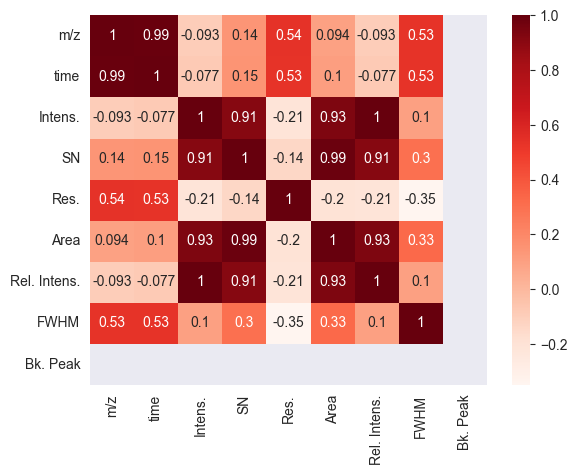

In [322]:
cor = example.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [323]:
## select uncorrelated features
FEATURES = ['m/z', 'Rel. Intens.', 'Res.', 'FWHM']

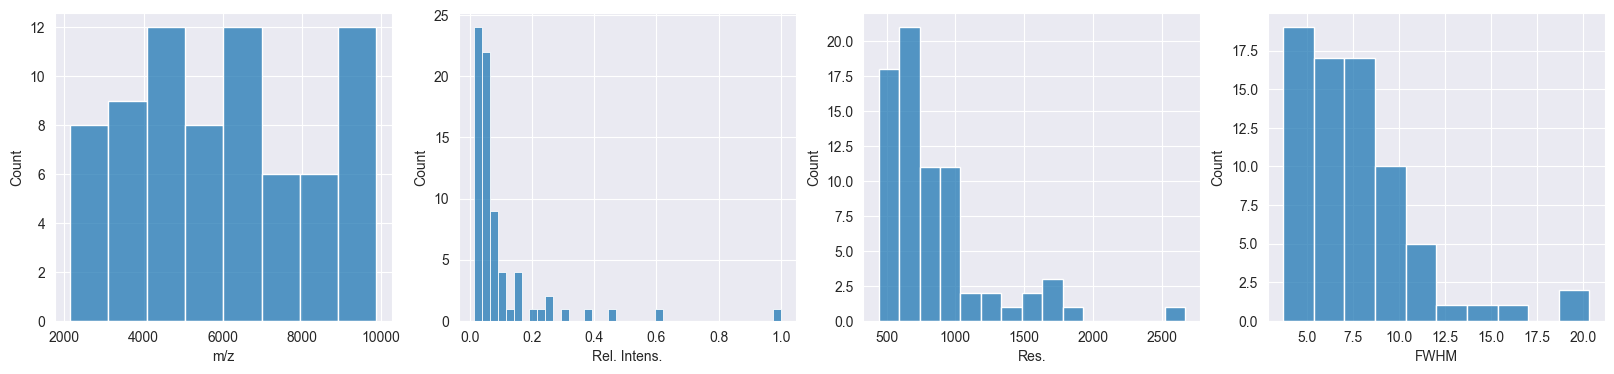

In [324]:
fig, axs = plt.subplots(1,4, figsize=(20, 4))
for features in FEATURES:
    sns.histplot(example[features], ax = axs[FEATURES.index(features)])

Посмотрим на масс-спектры для нескольих примеров

In [325]:
def colors_from_values(values, palette_name):
    values = np.array(values)
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

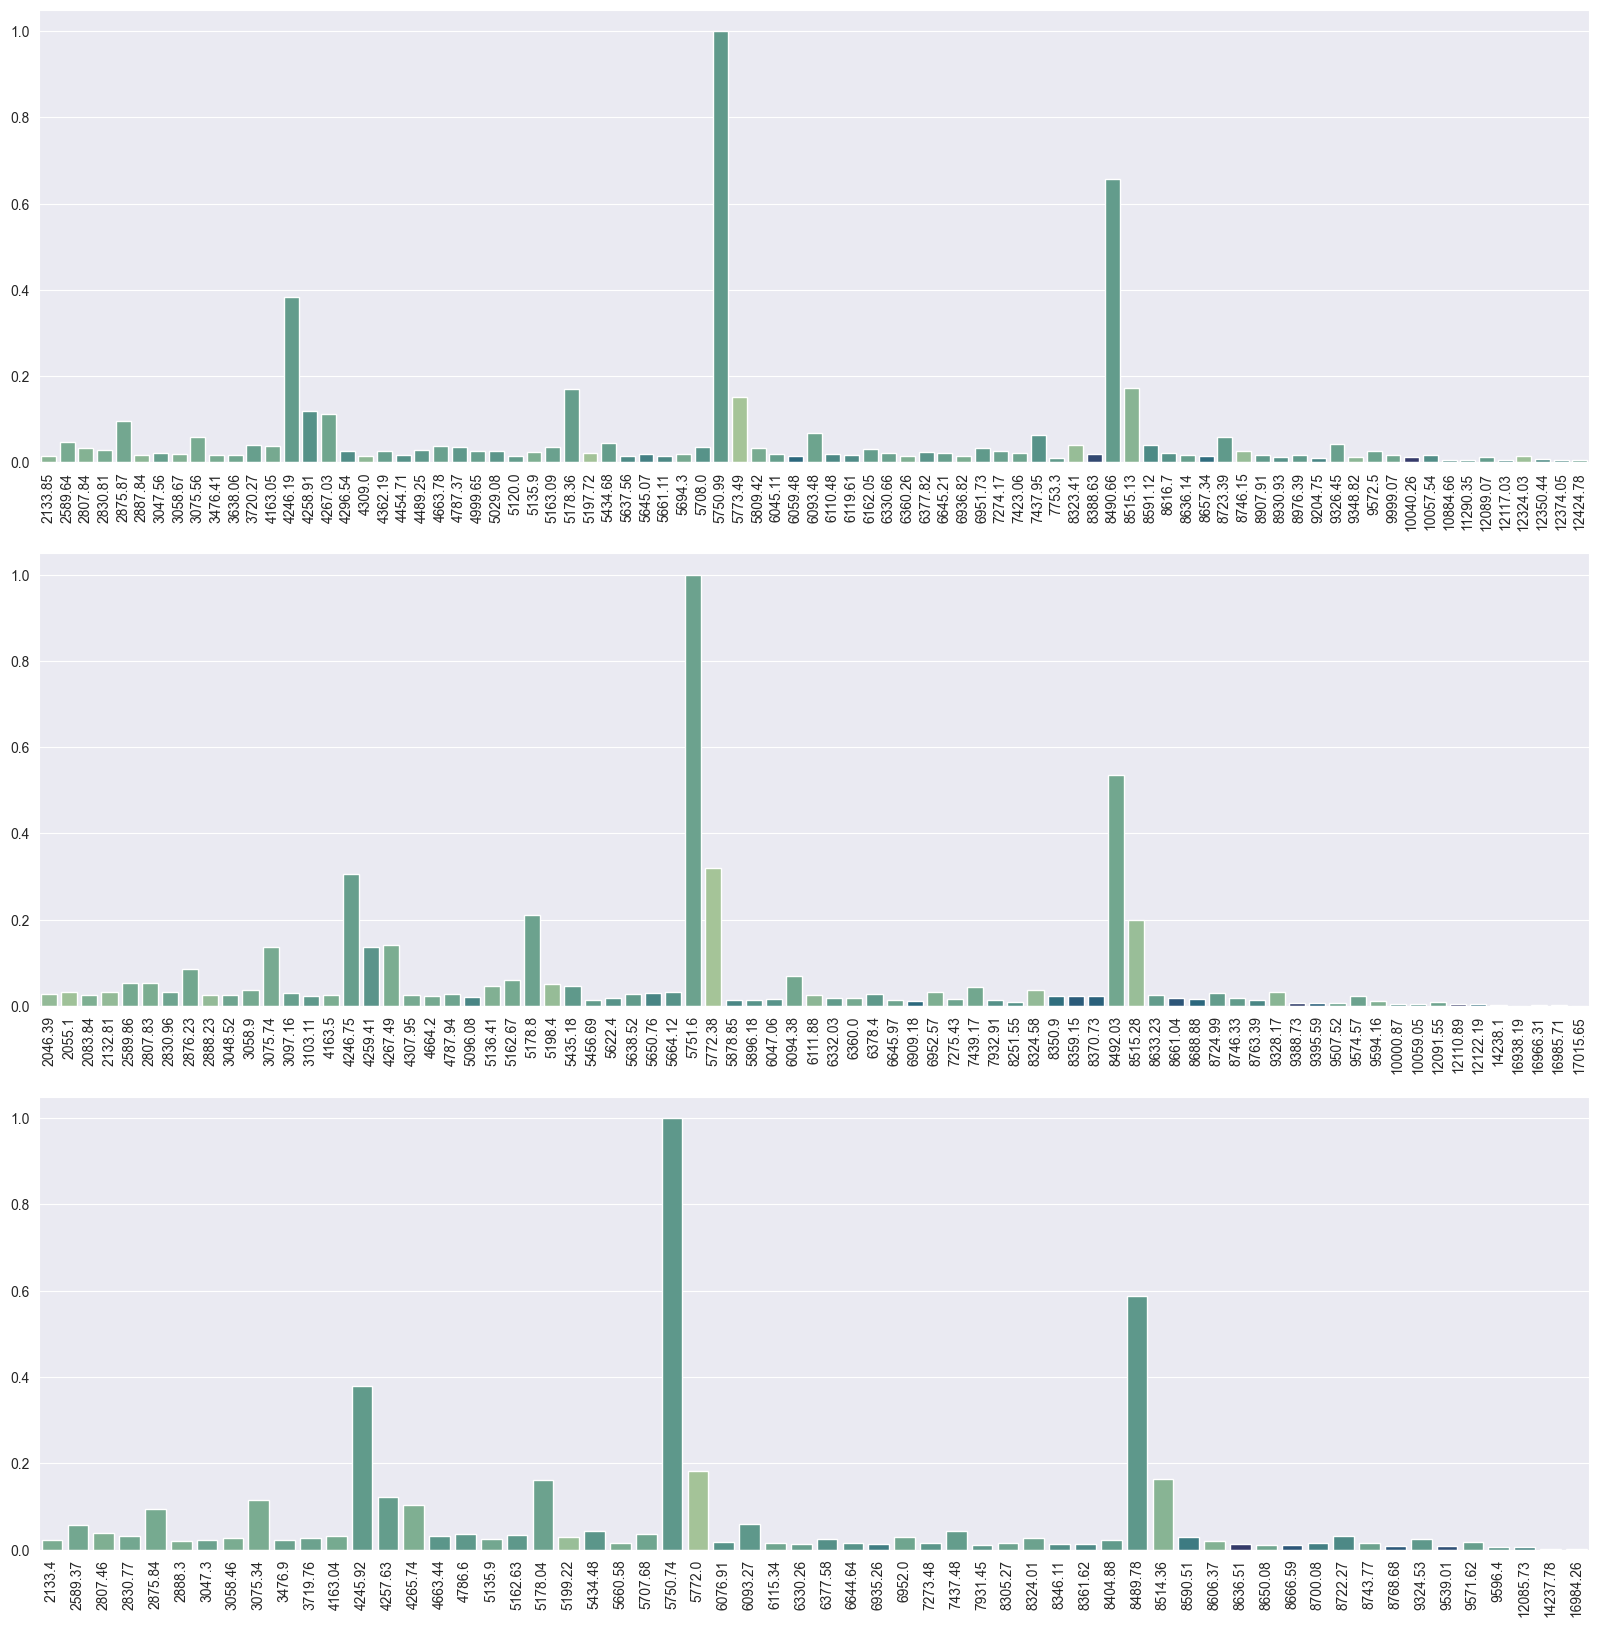

In [326]:
fig, axs = plt.subplots(3,1, figsize=(20,20))
strain = "Acinetobacter baumani_64"
i = 0
for ids in [2,6,8]:
    tmp = train_df.loc[(train_df.strain == strain)].iloc[ids]
    mz = [np.round(x, 2) for x in tmp['m/z']]
    ax =  axs[i]
    sns.barplot(data = tmp, x=mz, y = 'Rel. Intens.', 
                palette=colors_from_values(tmp['Res.'], 'crest'),
                ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    i=i+1

Создаим спектры, которые удобно сравнитвать между собой в виде векторов в фиксированом диапазоне, и уберем необходимость использовать переменную "m/z".

In [327]:
# орпеделим диапазон парамтеров
min(train_df['m/z'].apply(min)), max(train_df['m/z'].apply(max))

(2040.804289776974, 17241.93492389016)

In [328]:
def create_speactr(mz, intens):
    spec = []
    for i in range(200, 1750):
        if i in mz:
            spec.append(intens[mz.index(i)])
        else:
            spec.append(0)
    return spec

In [329]:
def prepocess_data(data):
    data['mz'] = data['m/z'].apply(lambda x: [int(x_i // 10) for x_i in x])
    data['intens'] = data.apply(lambda d: create_speactr(d['mz'], d['Rel. Intens.']),
                           axis = 1)
    return data

In [330]:
train_df = prepocess_data(train_df)

Перемешаем данные, чтобы классы не шли по порядку

In [331]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

# <center> Обучение моделей <center>

Разобьем выборку на валидационную и тренировочную так, чтобы хотя бы один пример из каждого класса присутствавал
в валидаицонной выборке. После разбиения уберем два класса из тренировочный выборки, чтобы можно было определить их 
как 'new'.

_Note_:  рекомендуем рассмотреть разные вариатны разбиения на тренировочную и валидационную выборку для определения оптиматльных парпамтеров. 

In [332]:
np.random.seed(142)
val_ds = pd.DataFrame()
train_ds = pd.DataFrame()
for strain in train_df.strain.unique():
    n = np.random.randint(1,4)
    ids = random.sample(list(train_df.loc[train_df.strain == strain].index), n)
    val_ds = pd.concat([val_ds, train_df.loc[ids]])
    train_ids = list(set(train_df.loc[train_df.strain == strain].index) - set(ids))
    train_ds = pd.concat([train_ds, train_df.loc[train_ids]])


In [333]:
val_ds.shape, train_ds.shape

((54, 13), (358, 13))

In [334]:
random.seed(111)
val_strain = random.sample(sorted(list(val_ds.strain.unique())), 2)
val_strain

['Acinetobacter baumani_64', 'Pseudomonas fluorescence_965']

In [335]:
train_ds = train_ds[~train_ds.strain.isin(val_strain)]

In [336]:
val_ds.loc[:,'target'] = val_ds.strain
val_ds.loc[val_ds.strain.isin(val_strain),'target'] = 'new'

In [337]:
val_ds = val_ds.sample(frac=1)
train_ds = train_ds.sample(frac=1)

In [338]:
def make_x(df, col):
    X = []
    for i in df.index:
        row = df.loc[i,col]
        X.append(row)
    return np.array(X)

## Нейросетевой классификатор

Закодируем штаммы:

In [526]:
from sklearn.preprocessing import LabelEncoder
train_ds['strain_encoded'] = LabelEncoder().fit_transform(train_ds['strain'])
train_df['strain_encoded'] = LabelEncoder().fit_transform(train_df['strain'])

decoder_sample = train_ds[['strain_encoded', 'strain']].drop_duplicates()
decoder_sample = decoder_sample.set_index('strain_encoded').to_dict()['strain']

decoder_full = train_df[['strain_encoded', 'strain']].drop_duplicates()
decoder_full = decoder_full.set_index('strain_encoded').to_dict()['strain']
pickle.dump(decoder_full, open(f'models/decoder.pkl', 'wb'))

In [505]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy

model = Sequential([
    Dense(64, input_shape=[len(train_ds['intens'][0])], activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(decoder_sample), activation='linear')
  ])

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [506]:
X = make_x(train_ds, col='intens')
y = np.array(train_ds['strain_encoded'])

In [507]:
model.fit(X, y, epochs=40)

Epoch 1/40
11/11 [==============================] - 0s 6ms/step - loss: 3.1476 - accuracy: 0.1280
Epoch 2/40
11/11 [==============================] - 0s 6ms/step - loss: 3.0700 - accuracy: 0.3476
Epoch 3/40
11/11 [==============================] - 0s 7ms/step - loss: 2.9535 - accuracy: 0.3506
Epoch 4/40
11/11 [==============================] - 0s 6ms/step - loss: 2.7872 - accuracy: 0.3811
Epoch 5/40
11/11 [==============================] - 0s 7ms/step - loss: 2.5838 - accuracy: 0.4146
Epoch 6/40
11/11 [==============================] - 0s 7ms/step - loss: 2.3518 - accuracy: 0.4329
Epoch 7/40
11/11 [==============================] - 0s 6ms/step - loss: 2.1208 - accuracy: 0.4848
Epoch 8/40
11/11 [==============================] - 0s 7ms/step - loss: 1.9203 - accuracy: 0.4939
Epoch 9/40
11/11 [==============================] - 0s 5ms/step - loss: 1.7526 - accuracy: 0.5610
Epoch 10/40
11/11 [==============================] - 0s 6ms/step - loss: 1.6140 - accuracy: 0.5793
Epoch 11/40
11/11 [

### проверяем качество модели на валидационной выборке

In [508]:
X_pred = make_x(val_ds, col='intens')
val_ds['target']

58            Staphilococcus aureus_15
209       Staphilococcus aureus_3 1027
186                Pseudomonas spp_467
200     Acinetobacter baumani_121 skin
370        Staphilococcus aureus_7 941
3         Staphilococcus aureus_3 1027
371           Staphilococcus aureus_16
52           Acinetobacter baumani_126
310        Staphilococcus aureus_4 948
138    Acinetobacter baumani_352 blood
214        Staphilococcus aureus_4 948
256        Staphilococcus aureus_1 949
284           Acinetobacter baumani_73
21          Pseudomonas aeruginosa_XXX
202      Staphilococcus aureus_12 K457
31                                 new
99           Acinetobacter baumani_126
262       Staphilococcus aureus_3 1027
76     Acinetobacter baumani_352 blood
233      Staphilococcus aureus_19 MRSA
384                Pseudomonas spp_467
185      Staphilococcus aureus_11 K817
343           Staphilococcus aureus_16
22       Staphilococcus aureus_12 K457
301        Staphilococcus aureus_8 942
276      Staphilococcus a

In [509]:
res = model.predict(X_pred)
class_name = []
for res_i in res:
    if max(res_i) > 0.0:
        class_name.append(decoder_sample[res_i.argmax()])
    else:
        class_name.append('new')

2/2 [==============================] - 0s 3ms/step


In [510]:
val_ds.loc[:,'class_name'] = class_name

In [511]:
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.8948571428571428

переобучим модель на всей тренировочной выборке, так как мы исключали классы для валидации

In [523]:
X = make_x(train_df, col='intens')
y = np.array(train_df['strain_encoded'])

model = Sequential([
    Dense(64, input_shape=[len(train_df['intens'][0])], activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(decoder_full), activation='linear')
  ])

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X, y, epochs=40)

Epoch 1/40
13/13 [==============================] - 0s 6ms/step - loss: 3.2291 - accuracy: 0.1529
Epoch 2/40
13/13 [==============================] - 0s 7ms/step - loss: 3.1227 - accuracy: 0.2937
Epoch 3/40
13/13 [==============================] - 0s 6ms/step - loss: 2.9545 - accuracy: 0.2888
Epoch 4/40
13/13 [==============================] - 0s 6ms/step - loss: 2.7057 - accuracy: 0.3083
Epoch 5/40
13/13 [==============================] - 0s 5ms/step - loss: 2.4091 - accuracy: 0.3350
Epoch 6/40
13/13 [==============================] - 0s 6ms/step - loss: 2.1207 - accuracy: 0.3617
Epoch 7/40
13/13 [==============================] - 0s 6ms/step - loss: 1.8860 - accuracy: 0.5267
Epoch 8/40
13/13 [==============================] - 0s 6ms/step - loss: 1.7036 - accuracy: 0.5995
Epoch 9/40
13/13 [==============================] - 0s 5ms/step - loss: 1.5385 - accuracy: 0.7354
Epoch 10/40
13/13 [==============================] - 0s 5ms/step - loss: 1.4039 - accuracy: 0.7694
Epoch 11/40
13/13 [

In [524]:
model.save("models/nn")

INFO:tensorflow:Assets written to: models/nn\assets


In [525]:
train_df["strain"]

0             Staphilococcus aureus_16
1       Acinetobacter baumani_121 skin
2          Staphilococcus aureus_7 941
3         Staphilococcus aureus_3 1027
4          Staphilococcus aureus_4 948
                    ...               
407           Acinetobacter baumani_63
408           Acinetobacter baumani_63
409    Acinetobacter baumani_377 blood
410           Acinetobacter baumani_73
411           Staphilococcus aureus_15
Name: strain, Length: 412, dtype: object